In [9]:
import gensim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy import spatial
from scipy.sparse import hstack, lil_matrix, csr_matrix

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import fbeta_score, make_scorer, accuracy_score
from sklearn.metrics.pairwise import paired_distances
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

import csv
import urllib.request
import io
import zipfile
import os

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kazak_hpyyfpn\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [10]:
!pip install gensim

## Preprocessing

Читаем данные и приводим их к нужному формату.

In [22]:
train = pd.read_json('multinli_1.0/multinli_1.0_train.jsonl', lines = True)
val_mismatched = pd.read_json('multinli_1.0/multinli_1.0_dev_mismatched.jsonl', lines = True)
val_matched = pd.read_json('multinli_1.0/multinli_1.0_dev_matched.jsonl', lines = True)
test_mismatched = pd.read_json('multinli_0.9_test_mismatched_unlabeled.jsonl', lines = True)
test_matched = pd.read_json('multinli_0.9_test_matched_unlabeled.jsonl', lines = True)
full = {'train': train, 'val_matched':val_matched, 'test_matched': test_matched, 'val_mismatched':val_mismatched, 'test_mismatched': test_mismatched}

Удаляем объекты, для которых не определен класс.

In [23]:
def delete_unsure_labels(data): 
    data = data.drop(index = data[data.gold_label == '-'].index)
    return data


for frame in full:
    full[frame] = delete_unsure_labels(full[frame])

In [24]:
train = full['train']
val_matched = full['val_matched']
val_mismatched = full['val_mismatched']
test_matched = full['test_matched']
test_mismatched = full['test_mismatched']

## Метрика

Создаем свою метрику с весами 0.8, 0.1 и 0.1.

In [25]:
def print_metric(y_true, y_preds):
    prfs = precision_recall_fscore_support(y_true, y_preds, beta=3, average=None, labels=['contradiction', 'neutral', 'entailment'])
    matrix_report = pd.DataFrame(prfs, columns = ['contradiction', 'neutral', 'entailment'], index = ['precision', 'recall', 'fscore', 'support'])
    matrix_report['Weighted*'] = 0.8 * matrix_report['contradiction'] +  0.1 * matrix_report['neutral'] +  0.1 * matrix_report['entailment']
    matrix_report.drop(index = 'support', inplace = True)
    print(f"{matrix_report.loc['fscore', 'Weighted*']:.4f}   Custom f-score")
    print(f"{matrix_report.loc['recall', 'contradiction']:.4f}   Contradiction's recall")
    print(f"{accuracy_score(y_true, y_preds):.4f}   Accuracy")
    print(matrix_report.T)

In [26]:
f_scorer = make_scorer(fbeta_score, beta=3, average='weighted', labels=['contradiction', 'neutral', 'entailment'])

## Training

Функция обучения модели

In [27]:
def log_reg_cv_and_validation(X_train, X_val, y_train, max_itr = 100):
    clf = LogisticRegression(solver = 'saga', max_iter = max_itr)

    scores = cross_val_score(clf, X_train, y_train, cv=3, scoring= f_scorer)
    print(f'Cross val scores: {scores}')
    print(f'Mean cross val score: {scores.mean():.4f}')
    print('-'*40)

    clf.fit(X_train, y_train)
    y_train_preds = clf.predict(X_train)
    y_val_preds = clf.predict(X_val)

    print('Train score')
    print_metric(y_train, y_train_preds)
    print('-'*40)

    print('Val score')
    print_metric(y_val, y_val_preds)

## Word2vec

Получаем вектора на основе word2vec и обучаем модель.

Скачиваем модель

In [28]:
zipFileURL = "https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip"
resp = urllib.request.urlopen(zipFileURL)
z_file = zipfile.ZipFile(io.BytesIO(resp.read()))

In [29]:
os.mkdir('w2v')
z_file.extractall(path = 'w2v')

In [30]:
model = gensim.models.KeyedVectors.load_word2vec_format('w2v/wiki-news-300d-1M.vec', binary=False)

Добавляем в данные столбцы с лемматизированными предложениями и со средними векторами каждого предложения

In [31]:
def avg_vec(words, model, num_features): # считает средний вектор
    feature_vec = np.zeros((num_features, ), dtype='float32')
    n_words = 0
    for word in words:
        if word in model:
            n_words += 1
            feature_vec = np.add(feature_vec, model[word])
    if (n_words > 0):
        feature_vec = np.divide(feature_vec, n_words)
    return feature_vec

In [32]:
def add_avg_vec(data, sent, model): # добавляет вектора в датафрейм
    data[f'{sent}_lemmas'] = data[sent].apply(lambda x: tokenizer.tokenize(x.lower()))
    data[f'{sent}_avgvec'] = data[f'{sent}_lemmas'].apply(lambda x: avg_vec(x, model, 300))

In [34]:
#for data in [train, val_mismatched, test_mismatched]:
for data in [train, val_matched, test_matched]:
    for sent in ['sentence1', 'sentence2']:
        add_avg_vec(data, sent, model)

In [35]:
def count_distances(data): 
    # преобразует предложения и считает расстояния(евклидово, матхэт., косинусное) между преобразованными предложениями
    vec_1 = np.array(data['sentence1_avgvec'].tolist())
    vec_2 = np.array(data['sentence2_avgvec'].tolist())
    euclidean = paired_distances(vec_1, vec_2, metric='euclidean')
    manhattan= paired_distances(vec_1, vec_2, metric='manhattan')
    cosine = paired_distances(vec_1, vec_2, metric='cosine')

    distances =  np.array([euclidean, manhattan, cosine]).T
    return distances

Считаем расстояния и обучаем модель

In [36]:
X_train = count_distances(train)
y_train = np.array(train['gold_label'])
X_val = count_distances(val_matched)
y_val = np.array(val_matched['gold_label'])
#X_val = count_distances(val_mismatched)
#y_val = np.array(val_mismatched['gold_label'])
X_test = count_distances(test_matched)
y_test = np.array(test_matched['gold_label'])
#X_test = count_distances(test_mismatched)
#y_test = np.array(test_mismatched['gold_label'])

In [37]:
log_reg_cv_and_validation(X_train, X_val, y_train = y_train, max_itr = 500)

Cross val scores: [0.41394902 0.41378991 0.4152407 ]
Mean cross val score: 0.4143
----------------------------------------
Train score
0.2989   Custom f-score
0.2403   Contradiction's recall
0.4210   Accuracy
               precision    recall    fscore
contradiction   0.381925  0.240315  0.249569
neutral         0.442135  0.345149  0.352890
entailment      0.426175  0.677683  0.639918
Weighted*       0.392371  0.294535  0.298936
----------------------------------------
Val score
0.3095   Custom f-score
0.2527   Contradiction's recall
0.4339   Accuracy
               precision    recall    fscore
contradiction   0.375578  0.252723  0.261270
neutral         0.449487  0.364713  0.371724
entailment      0.450869  0.663409  0.633544
Weighted*       0.390498  0.304991  0.309543


## TF-IDF

Считаем расстояния на основе метрики TF-IDF и обучаем модель

In [38]:
corpus = train.sentence1 +" "+ train.sentence2

In [39]:
nltk.download('stopwords')
stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kazak_hpyyfpn\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


Обучаем TF-IDF

In [40]:
tfidf = TfidfVectorizer(stop_words=stop)
tfidf.fit(corpus)

TfidfVectorizer(stop_words={'a', 'about', 'above', 'after', 'again', 'against',
                            'ain', 'all', 'am', 'an', 'and', 'any', 'are',
                            'aren', "aren't", 'as', 'at', 'be', 'because',
                            'been', 'before', 'being', 'below', 'between',
                            'both', 'but', 'by', 'can', 'couldn', "couldn't", ...})

In [41]:
def tfidf_distance(data):
    # преобразует предложения и считает расстояния(евклидово, матхэт., косинусное) между преобразованными предложениями
    data_sentence1 = tfidf.transform(data.sentence1)
    data_sentence2 = tfidf.transform(data.sentence2)
    difference = data_sentence1 - data_sentence2
    
    euclidean = paired_distances(data_sentence1, data_sentence2, metric='euclidean')
    manhattan= paired_distances(data_sentence1, data_sentence2, metric='manhattan')
    cosine = paired_distances(data_sentence1, data_sentence2, metric='cosine')

    distances =  hstack((np.array([euclidean, manhattan, cosine]).T, difference))
    return distances

Считаем расстояния, обучаем модель только TF-IDF

In [42]:
tfidf_train =  tfidf_distance(train)
tfidf_val = tfidf_distance(val_matched)
tfidf_test = tfidf_distance(test_matched)

In [43]:
log_reg_cv_and_validation(tfidf_train, tfidf_val, y_train = y_train, max_itr = 500)

Cross val scores: [0.47923332 0.47752134 0.4798659 ]
Mean cross val score: 0.4789
----------------------------------------
Train score
0.5419   Custom f-score
0.5196   Contradiction's recall
0.5791   Accuracy
               precision    recall    fscore
contradiction   0.594646  0.519560  0.526205
neutral         0.579014  0.584309  0.583775
entailment      0.566952  0.633359  0.626026
Weighted*       0.590313  0.537415  0.541944
----------------------------------------
Val score
0.4761   Custom f-score
0.4553   Contradiction's recall
0.5139   Accuracy
               precision    recall    fscore
contradiction   0.515141  0.455338  0.460686
neutral         0.495043  0.511687  0.509973
entailment      0.529223  0.569991  0.565634
Weighted*       0.514539  0.472438  0.476109


TF-IDF + word2vec

In [44]:
X_train = hstack((X_train, tfidf_train))
X_val = hstack((X_val, tfidf_val))
X_test = hstack((X_test, tfidf_test))

In [45]:
log_reg_cv_and_validation(X_train, X_val, y_train = y_train, max_itr = 500)

D:\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
D:\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
D:\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Cross val scores: [0.49721543 0.49644808 0.49877131]
Mean cross val score: 0.4975
----------------------------------------


D:\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Train score
0.5291   Custom f-score
0.5048   Contradiction's recall
0.5703   Accuracy
               precision    recall    fscore
contradiction   0.582250  0.504847  0.511649
neutral         0.569153  0.569305  0.569290
entailment      0.562078  0.636651  0.628315
Weighted*       0.578923  0.524473  0.529080
----------------------------------------
Val score
0.4789   Custom f-score
0.4550   Contradiction's recall
0.5239   Accuracy
               precision    recall    fscore
contradiction   0.517522  0.455026  0.460588
neutral         0.500619  0.517771  0.516003
entailment      0.548670  0.592986  0.588235
Weighted*       0.518947  0.475097  0.478895


## Синтаксис

Считаем расстояния на основе представлений graph2vec и обучаем модель

In [46]:
def read_csv_link(response): # читает вектора graph2vec из csv-файла
    spamreader = csv.reader(response)
    vectors = []
    i = 0
    for row in spamreader:
        if i == 0:
            i += 1
            continue
        row = [float(el) for el in row[1:]]
        vectors.append(row)
    return vectors

In [47]:
def count_distances_link(file1, file2): # считает расстояния между векторами
    vectors_1 = read_csv_link(file1)
    vectors_2 = read_csv_link(file2)
    vectors_1 = np.array([np.array(vectors_1[i]) for i in range(len(vectors_1))])
    vectors_2 = np.array([np.array(vectors_2[i]) for i in range(len(vectors_2))])
    dist_1 = vectors_1 - vectors_2
    
    euclidean = paired_distances(vectors_1, vectors_2, metric='euclidean')
    manhattan= paired_distances(vectors_1, vectors_2, metric='manhattan')
    cosine = paired_distances(vectors_1, vectors_2, metric='cosine')

    distances =  np.array([euclidean, manhattan, cosine]).T
    return distances

Скачиваем файлы с гитхаба (файлы подготовлены через модуль graph2vec отдельно, так как включение кода в данный файл нерационально)

In [48]:
response_val_1_1 = urllib.request.urlopen('https://raw.githubusercontent.com/ulianakazak/Bigutochki/main/val_1_1.csv')
response_val_2_1 = urllib.request.urlopen('https://raw.githubusercontent.com/ulianakazak/Bigutochki/main/val_2_1.csv')
response_val_1_2 = urllib.request.urlopen('https://raw.githubusercontent.com/ulianakazak/Bigutochki/main/val_1_2.csv')
response_val_2_2 = urllib.request.urlopen('https://raw.githubusercontent.com/ulianakazak/Bigutochki/main/val_2_2.csv')
response_test_1_1 = urllib.request.urlopen('https://raw.githubusercontent.com/ulianakazak/Bigutochki/main/test_1_1.csv')
response_test_2_1 = urllib.request.urlopen('https://raw.githubusercontent.com/ulianakazak/Bigutochki/main/test_2_1.csv')
response_test_1_2 = urllib.request.urlopen('https://raw.githubusercontent.com/ulianakazak/Bigutochki/main/test_1_2.csv')
response_test_2_2 = urllib.request.urlopen('https://raw.githubusercontent.com/ulianakazak/Bigutochki/main/test_2_2.csv')

X_val_1 = count_distances_link(io.TextIOWrapper(response_val_1_1), io.TextIOWrapper(response_val_2_1))
X_val_2 = count_distances_link(io.TextIOWrapper(response_val_1_2), io.TextIOWrapper(response_val_2_2))
semantic_val = np.vstack((X_val_1, X_val_2))

X_test_1 = count_distances_link(io.TextIOWrapper(response_test_1_1), io.TextIOWrapper(response_test_2_1))
X_test_2 = count_distances_link(io.TextIOWrapper(response_test_1_2), io.TextIOWrapper(response_test_2_2))
semantic_test = np.vstack((X_test_1, X_test_2))

In [49]:
response_1 = urllib.request.urlopen('https://raw.githubusercontent.com/ulianakazak/Bigutochki/main/data_syntax/train_1_0.csv')
response_2 = urllib.request.urlopen('https://raw.githubusercontent.com/ulianakazak/Bigutochki/main/data_syntax/train_2_0.csv')
semantic_train = count_distances_link(io.TextIOWrapper(response_1), io.TextIOWrapper(response_2))
for i in range(1, 69):
    response_1 = urllib.request.urlopen(f'https://raw.githubusercontent.com/ulianakazak/Bigutochki/main/data_syntax/train_1_{i}.csv')
    response_2 = urllib.request.urlopen(f'https://raw.githubusercontent.com/ulianakazak/Bigutochki/main/data_syntax/train_2_{i}.csv')
    X = count_distances_link(io.TextIOWrapper(response_1), io.TextIOWrapper(response_2))
    semantic_train = np.vstack((semantic_train, X))

In [50]:
def delete_unsure_labels_vec(X, data):
    X = X[data.index]
    return X

Обучаем модель, только для синтаксиса

In [52]:
semantic_train = delete_unsure_labels_vec(semantic_train, train)
semantic_val = delete_unsure_labels_vec(semantic_val, val_matched)
semantic_test = delete_unsure_labels_vec(semantic_test, test_matched)

In [53]:
log_reg_cv_and_validation(semantic_train, semantic_val, y_train = y_train, max_itr = 500)

Cross val scores: [0.32547094 0.32851701 0.33126737]
Mean cross val score: 0.3284
----------------------------------------
Train score
0.2663   Custom f-score
0.2301   Contradiction's recall
0.3352   Accuracy
               precision    recall    fscore
contradiction   0.335696  0.230071  0.237545
neutral         0.335466  0.413759  0.404322
entailment      0.334464  0.361645  0.358730
Weighted*       0.335550  0.261597  0.266342
----------------------------------------
Val score
0.1846   Custom f-score
0.1276   Contradiction's recall
0.3235   Accuracy
               precision    recall    fscore
contradiction   0.356212  0.127607  0.136358
neutral         0.318707  0.874480  0.744629
entailment      0.357895  0.009773  0.010826
Weighted*       0.352630  0.190511  0.184632


Синтаксис + TF-IDF + word2vec

In [54]:
X_train_all = hstack((X_train, semantic_train))
X_val_all = hstack((X_val, semantic_val))
X_test_all = hstack((X_test, semantic_test))

In [55]:
log_reg_cv_and_validation(X_train_all, X_val_all, y_train = y_train, max_itr = 500)

D:\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
D:\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
D:\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Cross val scores: [0.50524359 0.50383059 0.50798922]
Mean cross val score: 0.5057
----------------------------------------


D:\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Train score
0.4894   Custom f-score
0.4620   Contradiction's recall
0.5360   Accuracy
               precision    recall    fscore
contradiction   0.552311  0.461999  0.469679
neutral         0.524926  0.532124  0.531395
entailment      0.533775  0.613740  0.604682
Weighted*       0.547719  0.484185  0.489351
----------------------------------------
Val score
0.4822   Custom f-score
0.4650   Contradiction's recall
0.5125   Accuracy
               precision    recall    fscore
contradiction   0.511819  0.464986  0.469280
neutral         0.466175  0.567083  0.555068
entailment      0.569906  0.507330  0.512962
Weighted*       0.513063  0.479430  0.482227


Судя по кросс-валидации, данная модель улавливает закономерности хуже, чем предшествующие. Несмотря на то, на валидационной выборке recall у contradiction получился очень большой, итоговая метрика не выросла, т.к она также учитывает precision и recall на других классах.

## Fine-Tuning

Подбор итоговых параметров модели (запускается только один раз, снять комментарий для проверки)

In [ ]:
param_grid = {'penalty' : ['l2', 'none'], 
               'C': [0.1, 1., 3., 10],
              'solver': ['sag', 'saga', 'newton-cg'],} 
model = LogisticRegression(random_state=1, max_iter=500)
grid_classifier = GridSearchCV(model, param_grid, cv=3, scoring=f_scorer, return_train_score=True)
grid_classifier.fit(X_train, y_train)
results = pd.DataFrame(grid_classifier.cv_results_)
best = np.argmax(results.mean_test_score.values)

D:\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [57]:
results_file = results.to_csv('results_file.csv')

### Results

Результаты fine-tuning, файлы получены из отдельных запусков для каждого солвера

#### Saga

In [60]:
saga = pd.read_csv('clean_saga_results_file.csv')
saga

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,1,223.355759,0.533514,2.750779,0.016982,NaN,none,"{'C': none, 'penalty': 'none'}",0.654611,0.656727,0.653928,0.655089,0.001192,1.0,0.683840,0.687177,0.684087,0.685034,0.001518
1,6,223.116782,1.517500,2.761299,0.009427,10.0,l2,"{'C': 10, 'penalty': 'l2'}",0.654418,0.656508,0.653865,0.654930,0.001138,2.0,0.683403,0.686546,0.683599,0.684516,0.001438
2,4,221.807740,0.903589,2.756145,0.022261,3.0,l2,"{'C': 3.0, 'penalty': 'l2'}",0.654443,0.656299,0.653527,0.654756,0.001153,3.0,0.682256,0.685063,0.682413,0.683244,0.001288
3,2,213.774402,12.227167,2.681751,0.028854,1.0,l2,"{'C': 1.0, 'penalty': 'l2'}",0.654393,0.655246,0.652554,0.654064,0.001123,4.0,0.678754,0.680087,0.679185,0.679342,0.000556
4,0,103.525436,12.745608,2.737830,0.025990,0.1,l2,"{'C': 0.1, 'penalty': 'l2'}",0.644079,0.644651,0.641654,0.643461,0.001299,5.0,0.654325,0.653960,0.655176,0.654487,0.000509


In [61]:
y1_train = list(saga['mean_train_score'])
x1_train = [1 / i for i in list(saga['param_C'])]
x1_train[0] = 0
y1_test = list(saga['mean_test_score'])
x1_test = [1 / i for i in list(saga['param_C'])]
x1_test[0] = 0

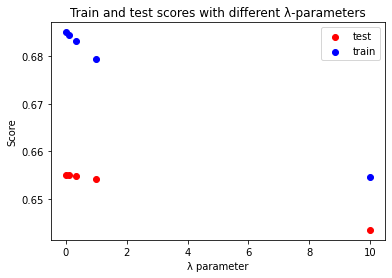

In [62]:
plt.scatter(x1_test, y1_test, label='test', color='red')
plt.scatter(x1_train, y1_train, label='train', color='blue')
plt.title('Train and test scores with different λ-parameters')
plt.ylabel('Score')
plt.xlabel('λ parameter')
plt.legend(loc='best')
plt.show()

#### Newton

In [63]:
newton = pd.read_csv('newton_results_file.csv')
newton

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0,78.934767,2.123762,3.140923,0.145401,0.1,{'C': 0.1},0.643379,0.644593,0.640910,0.642961,0.001533,4,0.653804,0.654202,0.654748,0.654252,0.000387
1,1,147.389531,2.203267,2.929313,0.063333,1.0,{'C': 1.0},0.655791,0.656259,0.654687,0.655579,0.000659,3,0.687068,0.686094,0.687579,0.686914,0.000616
2,2,209.724838,11.218258,3.056921,0.211266,3.0,{'C': 3.0},0.657131,0.658667,0.655925,0.657241,0.001122,1,0.700472,0.699782,0.700947,0.700401,0.000478
3,3,326.779914,16.252966,3.111567,0.135586,10.0,{'C': 10},0.656445,0.657580,0.655682,0.656569,0.000780,2,0.708133,0.707913,0.708402,0.708149,0.000200


In [64]:
y1_train = list(newton['mean_train_score'])
x1_train = [1 / i for i in list(newton['param_C'])]
y1_test = list(newton['mean_test_score'])
x1_test = [1 / i for i in list(newton['param_C'])]

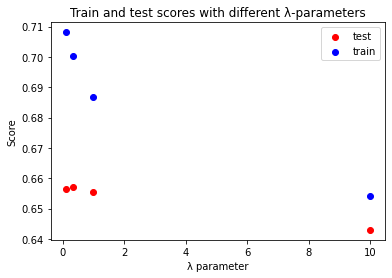

In [65]:
plt.scatter(x1_test, y1_test, label='test', color='red')
plt.scatter(x1_train, y1_train, label='train', color='blue')
plt.title('Train and test scores with different λ-parameters')
plt.ylabel('Score')
plt.xlabel('λ parameter')
plt.legend(loc='best')
plt.show()

#### Sag

In [66]:
sag = pd.read_csv('clean_sag_results_file.csv')
sag

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,6,241.486721,3.068361,2.934395,0.030746,10.0,l2,"{'C': 10, 'penalty': 'l2'}",0.656019,0.657736,0.655540,0.656432,0.000943,1.0,0.692262,0.695382,0.692584,0.693409,0.001401
1,1,248.163871,2.252929,2.961017,0.075998,NaN,none,"{'C': none, 'penalty': 'none'}",0.655920,0.657409,0.655377,0.656235,0.000859,2.0,0.693105,0.696756,0.693533,0.694465,0.001630
2,4,232.618460,13.245547,2.952045,0.064873,3.0,l2,"{'C': 3.0, 'penalty': 'l2'}",0.655639,0.657908,0.655052,0.656200,0.001232,3.0,0.688788,0.691714,0.690509,0.690337,0.001201
3,2,158.587228,17.776174,3.011639,0.180076,1.0,l2,"{'C': 1.0, 'penalty': 'l2'}",0.654653,0.655558,0.653545,0.654585,0.000823,4.0,0.681782,0.681569,0.681934,0.681762,0.000149
4,0,73.601931,5.882737,2.984545,0.086516,0.1,l2,"{'C': 0.1, 'penalty': 'l2'}",0.644095,0.644605,0.641808,0.643503,0.001216,5.0,0.654489,0.654166,0.655440,0.654698,0.000541


In [67]:
y1_train = list(sag['mean_train_score'])
x1_train = [1 / i for i in list(sag['param_C'])]
x1_train[1] = 0
y1_test = list(sag['mean_test_score'])
x1_test = [1 / i for i in list(sag['param_C'])]
x1_test[1] = 0

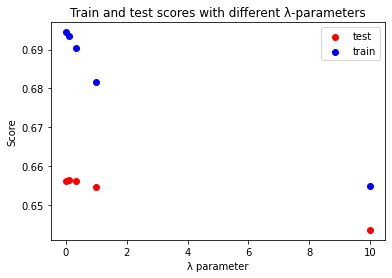

In [68]:
plt.scatter(x1_test, y1_test, label='test', color='red')
plt.scatter(x1_train, y1_train, label='train', color='blue')
plt.title('Train and test scores with different λ-parameters')
plt.ylabel('Score')
plt.xlabel('λ parameter')
plt.legend(loc='best')
plt.show()

## Total training

Итоговое обучение модели

In [69]:
max_itr = 500
solver = 'saga'
penalty = 'none'

In [70]:
clf = LogisticRegression(solver = solver, max_iter = max_itr, penalty = penalty)

scores = cross_val_score(clf, X_train, y_train, cv=3, scoring= f_scorer)
print(f'Cross val scores: {scores}')
print(f'Mean cross val score: {scores.mean():.4f}')
print('-'*40)

clf.fit(X_train, y_train)
y_train_preds = clf.predict(X_train)
y_val_preds = clf.predict(X_val)

print('Train score')
print_metric(y_train, y_train_preds)
print('-'*40)

print('Val score')
print_metric(y_val, y_val_preds)

D:\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
D:\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
D:\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Cross val scores: [0.4929771  0.4935327  0.49510663]
Mean cross val score: 0.4939
----------------------------------------


D:\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Train score
0.5343   Custom f-score
0.5106   Contradiction's recall
0.5746   Accuracy
               precision    recall    fscore
contradiction   0.584651  0.510622  0.517171
neutral         0.574966  0.573117  0.573301
entailment      0.566524  0.640081  0.631877
Weighted*       0.581870  0.529818  0.534254
----------------------------------------
Val score
0.4796   Custom f-score
0.4560   Contradiction's recall
0.5243   Accuracy
               precision    recall    fscore
contradiction   0.516937  0.455960  0.461403
neutral         0.502333  0.517131  0.515612
entailment      0.548593  0.593849  0.588990
Weighted*       0.518642  0.475866  0.479582


## Результаты

Получение и сохранение результатов на тестовой выборке

In [75]:
y_test_preds = clf.predict(X_test)

print('Test score')
print_metric(y_test, y_test_preds)
print('-'*40)

Test score
0.0000   Custom f-score
0.0000   Contradiction's recall
0.0000   Accuracy
               precision  recall  fscore
contradiction        0.0     0.0     0.0
neutral              0.0     0.0     0.0
entailment           0.0     0.0     0.0
Weighted*            0.0     0.0     0.0
----------------------------------------


D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [74]:
output = pd.DataFrame({'pairID': test_matched.pairID, 'predicted_label': y_test_preds}) 
output.to_csv('results.csv', index=False)